# Problem 1

**Capacitated facility location**

You need to solve a *capacitated facility location* problem. There are a number of clients that can be served by a number of potential facilities. As in the case of a common (uncapacitated) facility location problem, you need to decide which facilities to open (paying the opening cost for each) and which clients to serve at each facility (paying the assignment cost). Each client must be assigned to one opened facility. In addition, you have a cap on how many clients each facility can serve. As usual, you want to minimize the costs.

Implement the following algorithms and investigate them. Use the below code to generate the data, and to visualize the results. You are supposed to play with different configurations and problem sizes. Please make your report detailed (otherwise lower amount of points than indicated may be assigned).

* (2 points). Implement a **greedy algorithm** for the problem.
* (3 points). Implement **some local optimization algorithm**. Try to design powerful moves that are at the same time easy to search through. **Important:** your move should connect the whole domain, i.e. for any pair of feasible solutions, there should exist a sequence of moves from the family you design that transform one solution to the other.
* (3 points). Implement the **simulated annealing algorithm** based on the best of your local optimization algorithms. Play with the schedule and see how it affects the results. Compare with the local optimization algorithm that you base upon. Note, that if implemented correctly, simulated annealing should improve over the local optimization algorithm.

Below is the Gurobi solution that uses a mixed-integer solver (we will come to that in week 3). You can use it as a reference for small instances (for which it will give you a global optimum), and also reuse the visualization code.

Before writing your code, study the cells below to learn variables, convention for the solution format etc.

In [261]:
import numpy as np
import scipy as sp
from numpy import random
from numpy import matlib
import matplotlib.pyplot as plt
from gurobipy import GRB
import gurobipy as grb

%matplotlib inline

class Problem:
    def __init__(self, C=20, F=15):
        self.C = C
        self.F = F
        
        self.clients = np.random.rand(2, C)    # client positions
        self.facilities = np.random.rand(2, F) # facility positions

        # maximum number of clients per facility
        self.capacities = np.ones((F,), dtype=np.int32)*4;

        # assignment cost is defined as the squared distance between a client and a facility
        dx = \
            np.matlib.repmat(self.clients[0,:],F,1) - \
            np.matlib.repmat(self.facilities[0,:],C,1).transpose();
        dy = \
            np.matlib.repmat(self.clients[1,:],F,1) - \
            np.matlib.repmat(self.facilities[1,:],C,1).transpose();

        self.assignment_costs = 3*(dx*dx + dy*dy);

        self.opening_costs = np.ones((F,));
    
    def assign_random_capacities(self):
        """
        Assign more or less random capacities to facilities.
        
        This is one of the possible ways to change the problem configuration.
        In other words, use this function when testing your solution!
        """
        while True:
            self.capacities = \
                np.random.randint(2*self.C // self.F, size=self.F) + 1
            if sum(self.capacities) > self.C * 1.3:
                break
    
    def assign_random_capacities2(self):#this is my function,
        #I added it to generate the last instance in testing section
        
        while True:
            self.capacities = \
                np.random.randint(7*self.C // self.F, size=self.F) + 1
            if sum(self.capacities) > self.C * 1.3:
                break
                
    def assign_random_opening_costs(self):
        """
        Assign more or less random opening costs to facilities.
        
        Same as above -- use this for your report.
        """
        # could be float, but let it be simple
        self.opening_costs = \
            np.random.randint((self.C+self.F-1) // self.F, size=self.F) + 1
    
    def plot(self, y, assignments, fig=plt):
        """
        Plot the given solution (y, assignments)
        
        Arguments:
        y, assignments -- see Problem.objective().
        fig            -- an instance of matplotlib.axes._axes.Axes to draw on.
                          Also, can be matplotlib.pyplot, in this case use the default Axes.
                          This is useful to compare your results (see "Results comparison" section).
        """
        
        y = np.array(y, dtype='int32')
        assignments = np.array(assignments, dtype='int32')
        
        for cli,fac in enumerate(assignments):
            fig.plot([self.clients[0,cli], self.facilities[0,fac]], \
                     [self.clients[1,cli], self.facilities[1,fac]], c=(.7,.7,.7))
            
        fig.scatter(self.clients[0,:], self.clients[1,:], s=15.0, c=assignments, \
                    vmin=0, vmax=self.F-1)
        
        fig.scatter(self.facilities[0,:], self.facilities[1,:], s=54.0, \
                    c=range(self.F), linewidth = [1*el for el in y], marker=',')
        
    def objective(self, y, assignments):
        """
        Return objective function value given a solution.
        If the solution is infeasible, return infinity.
        
        Arguments:
        y           -- a binary 1D array of size F. y[i] is 1 iff i-th facility is open.
        assignments -- an integer 1D array of size C. assignments[i] is index of facility
                       that i-th client is assigned to.
        """
        assert len(y) == self.F
        assert len(assignments) == self.C
        
        y = np.array(y, dtype='int32')
        assignments = np.array(assignments, dtype='int32')
        print(assignments)
        retval = sum(is_opened*opening_cost \
                     for is_opened, opening_cost in zip(y, self.opening_costs))
        
        assignment_counts = np.zeros_like(y)
        
        for cli,fac in enumerate(assignments):
            if (not y[fac]):
                return np.inf
            else:
                retval += self.assignment_costs[fac,cli]
                assignment_counts[fac] += 1
                
        if any(assignment_counts > self.capacities):
            return np.inf
            
        return retval
        
    def solve_gurobi(self, verbose=False):
        """
        Solve the problem using mixed integer program solver.
        Return `y, assignments` (see Problem.objective() docstring for format).
        
        Arguments:
        verbose -- controls Gurobi output.
        """
        m = grb.Model("facility")

        y = []
        for i_f in range(self.F):
            y.append(m.addVar(vtype=GRB.BINARY))

        x = []    
        for i_f in range(self.F):
            x.append([])
            for i_c in range(self.C):
                x[i_f].append(m.addVar(vtype=GRB.BINARY))

        # the objective is to minimize the total fixed and variable costs
        m.modelSense = GRB.MINIMIZE

        # update model to integrate new variables
        m.update()

        # set optimization objective - minimize sum of fixed costs
        obj_summands = []
        for i_f in range(self.F):
            obj_summands.append(self.opening_costs[i_f]*y[i_f])

        for i_f in range(self.F):
            for i_c in range(self.C):
                obj_summands.append(self.assignment_costs[i_f][i_c]*x[i_f][i_c])

        m.setObjective(grb.quicksum(obj_summands))

        # set constraints
        for i_c in range(self.C):
            client_constr_summands = [x[i_f][i_c] for i_f in range(self.F)]
            m.addConstr(sum(client_constr_summands), GRB.EQUAL, 1.0)

        for i_f in range(self.F):        
            facility_constr_summands = [x[i_f][i_c] for i_c in range(self.C)]
            m.addConstr(sum(facility_constr_summands), \
                        GRB.LESS_EQUAL, self.capacities[i_f]*y[i_f])       

        for i_f in range(self.F):        
            for i_c in range(self.C):
                m.addConstr(x[i_f][i_c], GRB.LESS_EQUAL, y[i_f])

        # optimize
        m.setParam(GRB.Param.OutputFlag, verbose)
        m.optimize()
        
        facilities_opened = [np.int(y[i_f].X) for i_f in range(self.F)]
        clients_assignment = \
            [i_f for i_c in range(self.C) for i_f in range(self.F) if x[i_f][i_c].X != 0]
        print("GRBOUT ",clients_assignment)
        print("GRBOUT ",facilities_opened)
        return facilities_opened, clients_assignment

The following example shows `Problem` class usage.

[ 4 11 10 12  6 14  5  0  7  9  3  2  4 11 10 12  6 14  5  0]
GRBOUT  [14, 8, 10, 14, 7, 0, 10, 11, 2, 12, 1, 6, 1, 8, 12, 6, 5, 11, 0, 5]
GRBOUT  [1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1]
[14  8 10 14  7  0 10 11  2 12  1  6  1  8 12  6  5 11  0  5]


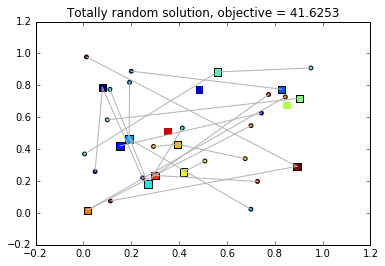

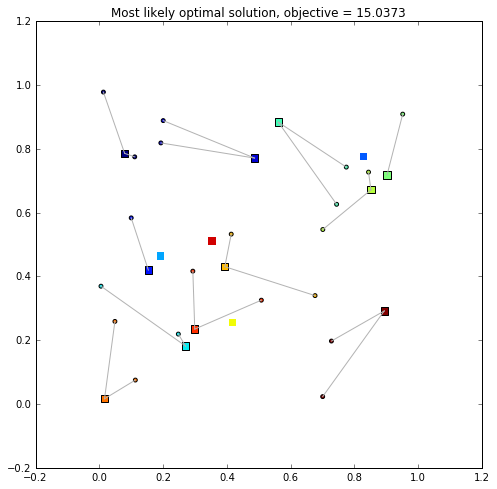

In [14]:
# to make results reproducible, be sure to put this line before creating a Problem()
np.random.seed(666)

problem = Problem()
problem.assign_random_capacities()
problem.assign_random_opening_costs()

# completely random solution
open_idx = list(range(problem.F))
random.shuffle(open_idx)
open_idx = open_idx[:problem.F * 4 // 5] # open 80% of facilities

y = np.zeros(problem.F)
y[open_idx] = 1

from itertools import cycle
assignments = np.empty(problem.C)
for cli, fac in zip(range(problem.C), cycle(open_idx)):
    assignments[cli] = fac

ax = plt.figure().gca()
problem.plot(y, assignments, ax)
ax.set_title('Totally random solution, objective = %.4f' % problem.objective(y, assignments))

ax = plt.figure(figsize=(8,8)).gca()
y, assignments = problem.solve_gurobi()
problem.plot(y, assignments, ax)
ax.set_title('Most likely optimal solution, objective = %.4f' % problem.objective(y, assignments))

## Greedy algorithm

### Defining the solution

I thought it would be easier to deal with objects instead of matrices, so I define new classes to opearate with. These are Facility, Client and Solution described below with some utilities inside.

In [263]:
class Facility:
    def __init__(self,loc,opCost,cpcty,Id):
        self.id=Id
        self.location=loc
        self.openingCost=opCost
        self.capacity=cpcty
        
class Client:
    def __init__(self,loc,assignTo=-1):
        self.location=loc
        self.assignment=assignTo
        
class Solution:
    def __init__(self,faclts=np.array([],dtype='object'),clnts=np.array([],dtype='object')):
        self.clients=clnts
        self.facilities=faclts
        self.cost=-1
        self.feasible=False
        
    def ComputeCost(self):
        if(len(self.clients)==0 or len(self.facilities)==0 or np.any([cl.assignment==-1 for cl in self.clients])):
            self.cost=-1
        else:
            self.cost=0
            ids=set([])
            for cl in self.clients:
                if(cl.assignment.id not in ids):
                    ids.add(cl.assignment.id)
                    self.cost=self.cost+cl.assignment.openingCost
                
            self.cost= self.cost + np.sum([np.linalg.norm(cl.location-cl.assignment.location,2)**2 for cl in self.clients])
        return self.cost
    
    def CheckFeasibility(self):
        #each client is assigned to exactly one facility
        if(np.all([not(cl.assignment==-1) for cl in self.clients])):
            #each facility does not exceed its capacity
            if(np.all([np.sum([int(cl.assignment==fac) for cl in self.clients])<=fac.capacity for fac in self.facilities])):
                self.feasible=True
                return True
            else:
                self.feasible=False
                return False
        else:
            self.feasible=False
            return False
        
    def AssignNearestFacilities(self):
        capacitiesLeft=np.array([fac.capacity for fac in self.facilities])
        for cl in self.clients:
            availableFacs=np.arange(len(self.facilities))[capacitiesLeft>0]
            #print(len(availableFacs))
            #print(len(self.facilities))
            k=np.argmin([np.linalg.norm(cl.location-fac.location,2) for fac in self.facilities[availableFacs]])
            k=availableFacs[k]
            cl.assignment=self.facilities[k]
            capacitiesLeft[k]=capacitiesLeft[k]-1
                
        

Firstly, we can obtain a lower bound for cost by assigning clients to closest facility. Indeed, if some capacity contraints are violated in this case, one needs to swap clients between facilities and increase total distance.

In [264]:
def NNLowerBound(sol):
    cost=0
    for cl in sol.clients:
        cost=cost+np.min(np.array([np.linalg.norm(cl.location-fac.location,2)**2 for fac in sol.facilities]))

    return cost
        

Secondly, we are able to easily detect infeasibility by comparing total capacity and number of clients.

In [265]:
def CheckEarlyFeasibility(sol):
    cap=np.sum([fac.capacity for fac in sol.facilities])
    if(cap>=len(sol.clients)):
        return True
    else:
        return False

I have implemented the nearest facility heuristic with capacity constraints to assign clients to facilities in an optimized greedy manner. NNLowerBound was used as a lower bound and we try to enumerate all possible facility openings. In each opening we assign clients to closest facilities with check of capacity violation.

In [275]:
def solve_greedy(self, max_iter=2**20):
    y = np.zeros(self.F, dtype=np.int32)
    assignments = np.empty(self.C, dtype=np.int32)
    
    # your code here
    print(self.facilities[:,0])
    facs0=np.array([Facility(self.facilities[:,i],self.opening_costs[i],self.capacities[i],i) for i in range(0,self.F)],dtype='object')
    cls0=np.array([Client(self.clients[:,i],-1) for i in range(0,self.C)],dtype='object')
    sol0 = Solution(facs0,cls0)
    
    
    opened=np.zeros(self.F,dtype='bool')
    k=0
    opt=np.Inf
    solOpt = None
    y=np.zeros(self.F,dtype='bool')
    print('Greedy algorithm is working')
    while(k<np.min([max_iter,2**self.F])):
        k=k+1
        
        #+1 to boolean array
        j0=len(opened)-1
        while(j0>=0 and opened[j0]):
            opened[j0]=False
            j0=j0-1    
        if(j0>=0):
            opened[j0]=True
        
        assFacs=sol0.facilities[opened]
        sol=Solution(assFacs,np.copy(sol0.clients))
        if(CheckEarlyFeasibility(sol)):
            if(NNLowerBound(sol0)+np.sum([fac.openingCost for fac in assFacs])<opt):
                sol.AssignNearestFacilities()
                if(sol.ComputeCost()<opt):
                    opt=sol.cost
                    #print("New optimal Cost!",opt)
                    y=np.copy(opened)
                    #print(np.any([not(y[cl.assignment.id]) for cl in sol.clients]))
                    assignments=[cl.assignment.id for cl in sol.clients]
                    
    
    
    print(assignments)    
    y=np.array(y,dtype='int32')    
    print(y)
    
    return y, assignments

Problem.solve_greedy = solve_greedy


*(Demonstrate your greedy algorithm here)*
So, here is the solution obtained with greedy algorithm. Its cost is about 110% of optimal one.

In [242]:
#problem = Problem()
#problem.assign_random_capacities()
#problem.assign_random_opening_costs()

y, assignments=problem.solve_greedy()

[ 0.07934213  0.78613657]
Greedy algorithm is working
[14, 8, 14, 10, 7, 0, 10, 2, 0, 12, 1, 8, 1, 6, 12, 6, 5, 11, 5, 11]
[1 1 1 0 0 1 1 1 1 0 1 1 1 0 1]


[14  8 14 10  7  0 10  2  0 12  1  8  1  6 12  6  5 11  5 11]
[1 1 1 0 0 1 1 1 1 0 1 1 1 0 1]
[14, 8, 14, 10, 7, 0, 10, 2, 0, 12, 1, 8, 1, 6, 12, 6, 5, 11, 5, 11]


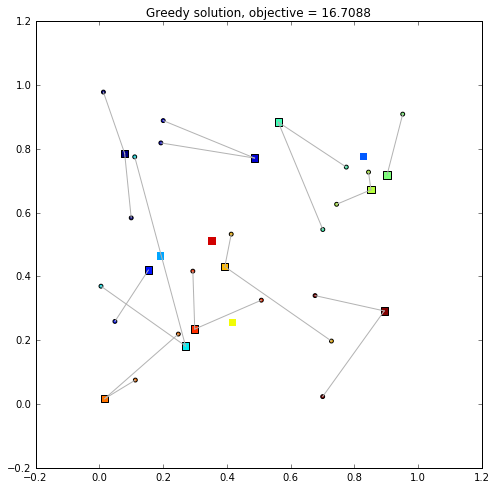

In [243]:
ax = plt.figure(figsize=(8,8)).gca()
problem.plot(y,assignments)
ax.set_title('Greedy solution, objective = %.4f' % problem.objective(y, assignments))
print(y)
print(assignments)

## Local optimization algorithm

Consider the set of local moves consisting of re-assignements of one client and all $$K1-K2$$ swaps of $K1$ clients of one facility with $K2$ clients of another one. These local moves keep the domain connected because we can obtain any feasible solution using only re-assignments of clients. These are not really powerful for local optimization, so I also consider swaps.

On each step of the algorithm the neighbourhood of current solution is generated and the best improvement in it is chosen. The process goes iteratively until there are no improvements at all. All improvements which are not valid or increase the cost function are not considered.

Theoretically we can start with any feasible solution, but after some tests I decided to use greedy solution as the initial point. Random initial solutions resulted in very costly result.

*(Describe your local optimization algorithm here. Make sure that its moves cover the whole solution domain)*

In [273]:
import itertools as it
def dist(x,y):
    return np.linalg.norm(x-y,2)**2

def GetK1K2Neighbourhood(sol,probl,K1=2,K2=2):
    
    (C,F)=sol.shape
    neighbourhood = []
    for i in np.arange(0,F-1):
        for j in np.arange(i+1,F):
            clients_i=np.arange(0,C)[sol[:,i]>0]
            clients_j=np.arange(0,C)[sol[:,j]>0]
            
            if(len(clients_i)==0 and len(clients_j)==0):
                continue
            
            if(not(len(clients_i)==0) and len(clients_j)==0):
                dcost_j=probl.opening_costs[j]
            else:
                dcost_j=0
                
            if(not(len(clients_j)==0) and len(clients_i)==0):
                continue #already considered by symmetry
            
            #simple reassigns, if clients_i is non-empty
            for k1 in range(1,np.min([K1+1,len(clients_i)+1])):
                if(probl.capacities[j]-len(clients_j)>=k1):
                    
                    if(k1>1):
                        combs=list(it.combinations(clients_i,k1))
                    else:
                        combs=[[cl] for cl in clients_i]
                            
                    for comb in combs:
                        dcost=+dcost_j-np.sum([dist(probl.clients[:,cl],probl.facilities[:,i]) for cl in comb])
                        dcost=dcost+np.sum([dist(probl.clients[:,cl],probl.facilities[:,j]) for cl in comb])
                        if(dcost<0):
                            #print("WOW")
                            neighbourhood.append([i,j,np.copy(comb),np.array([]),dcost])
    
            #k1>0,k2>0
            for k1 in range(1,np.min([K1+1,len(clients_i)+1])):
                for k2 in range(1,np.min([K2+1,len(clients_j)+1])):
                    if(probl.capacities[j]-len(clients_j)+k2>=k1 and probl.capacities[i]-len(clients_i)+k1>=k2):
                        if(k1>1):
                            combs_i=list(it.combinations(clients_i,k1))
                        else:
                            combs_i=[[cl] for cl in clients_i]

                        if(k2>1):
                            combs_j=list(it.combinations(clients_j,k2))
                        else:
                            combs_j=[[cl] for cl in clients_j]

                        for comb_i in combs_i:
                            for comb_j in combs_j:
                                dcost=-np.sum([dist(probl.clients[:,cl],probl.facilities[:,i]) for cl in comb_i])
                                dcost=dcost-np.sum([dist(probl.clients[:,cl],probl.facilities[:,j]) for cl in comb_j])
                                dcost=dcost+np.sum([dist(probl.clients[:,cl],probl.facilities[:,i]) for cl in comb_j])
                                dcost=dcost+np.sum([dist(probl.clients[:,cl],probl.facilities[:,j]) for cl in comb_i])
                                if(dcost<0):
                                    neighbourhood.append([i,j,np.copy(comb_i),np.copy(comb_j),dcost]) # CONVENTION!


    return neighbourhood

def ApplyLocalMove(sol, move):
    #print(move)
    #[i,j,np.copy(comb_i),np.copy(comb_j),dcost]) # CONVENTION!
    sol[move[2],move[0]]=0 #unassign people from factory 1
    sol[move[2],move[1]]=1 #assign them to factory 2
    if(len(move[3])>0):
        sol[move[3],move[1]]=0 #unassign people from factory 2
        sol[move[3],move[0]]=1 #assign them to factory 1
        
    return sol
    
def solve_local_optimization(self,max_it=2**15):
    y, assignments = self.solve_greedy(max_iter=max_it)#start solution obtained with greedy algorithm
    
    #ax = plt.figure(figsize=(8,8)).gca()
    #self.plot(y,assignments)
    #ax.set_title('Greedy solution, objective = %.4f' % problem.objective(y, assignments))
    
    sol=np.zeros((self.C,self.F))
    for i in np.arange(0,len(assignments)):
        #print(assignments[i])
        sol[i,np.int(assignments[i])]=1
    
    print("Local Search is working")
    nb = GetK1K2Neighbourhood(sol,self,3,3)
    
    
    
    while(len(nb)>0): #while we can improve
        nbMove_opt = np.argmin([nbmember[4] for nbmember in nb])#get the best local move
        nbMove_opt = nb[nbMove_opt]
        sol=ApplyLocalMove(sol,nbMove_opt)
        #print("Objective's Change",nbMove_opt[4])
        nb = GetK1K2Neighbourhood(sol,self,3,3)
        
    assignments = np.array([np.argmax(sol[clientId,:]) for clientId in np.arange(self.C)])
    y = np.zeros(self.F)
    y[np.unique(assignments)]=1
    return y, assignments


Problem.solve_local_optimization = solve_local_optimization



[ 0.07934213  0.78613657]
Greedy algorithm is working
[14, 8, 14, 10, 7, 0, 10, 2, 0, 12, 1, 8, 1, 6, 12, 6, 5, 11, 5, 11]
[1 1 1 0 0 1 1 1 1 0 1 1 1 0 1]
Local Search is working
[14  8 10 14  7  0 10 11  2 12  1  6  1  8 12  6  5 11  0  5]
[ 1.  1.  1.  0.  0.  1.  1.  1.  1.  0.  1.  1.  1.  0.  1.]
[14  8 10 14  7  0 10 11  2 12  1  6  1  8 12  6  5 11  0  5]
[2 2 1 1 2 2 2 1 2 2 2 2 2 2 2]


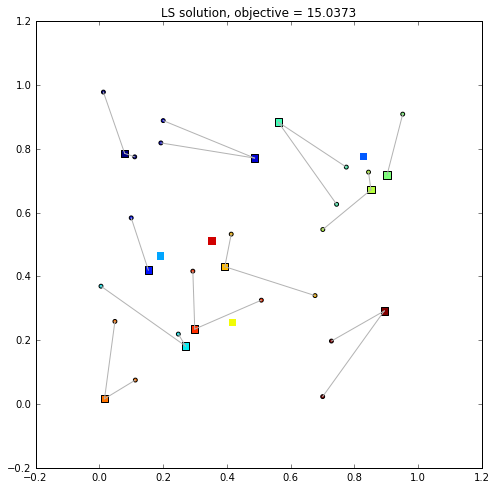

In [247]:
y_ls, assignments_ls = problem.solve_local_optimization()
ax = plt.figure(figsize=(8,8)).gca()
problem.plot(y_ls,assignments_ls)
ax.set_title('LS solution, objective = %.4f' % problem.objective(y_ls, assignments_ls))
print(y_ls)
print(assignments_ls)
print(problem.capacities)

*(Demonstrate your local optimization algorithm here)*

We can see that we have got the solution obtained by Gurobi and considering the small size of the problem, it is most likely the optimal solution.

## Simulated annealing

We use the same neighbourhoods as above, but also take non-improvements into consideration. The initial solution is set 'somehow' which means deterministically, but very straightforward. Still it results in reasonable solutions. We also could try random initial assignment, but it resulted in very costly solutions. 

In [268]:
def GetK1K2Neighbourhood_annealing(sol,probl,K1=2,K2=2):
    
    (C,F)=sol.shape
    neighbourhood = []
    for i in np.arange(0,F-1):
        for j in np.arange(i+1,F):
            clients_i=np.arange(0,C)[sol[:,i]>0]
            clients_j=np.arange(0,C)[sol[:,j]>0]
            
            if(len(clients_i)==0 and len(clients_j)==0):
                continue
            
            if(not(len(clients_i)==0) and len(clients_j)==0):
                dcost_j=probl.opening_costs[j]
            else:
                dcost_j=0
                
            if(not(len(clients_j)==0) and len(clients_i)==0):
                continue #already considered by symmetry
            
            #simple reassigns, if clients_i is non-empty
            for k1 in range(1,np.min([K1+1,len(clients_i)+1])):
                if(probl.capacities[j]-len(clients_j)>=k1):
                    
                    if(k1>1):
                        combs=list(it.combinations(clients_i,k1))
                    else:
                        combs=[[cl] for cl in clients_i]
                            
                    for comb in combs:
                        dcost=+dcost_j-np.sum([dist(probl.clients[:,cl],probl.facilities[:,i]) for cl in comb])
                        dcost=dcost+np.sum([dist(probl.clients[:,cl],probl.facilities[:,j]) for cl in comb])
                        #if(dcost<0):  #consider also non-improvements
                            #print("WOW")
                        neighbourhood.append([i,j,np.copy(comb),np.array([]),dcost])
    
            #k1>0,k2>0
            for k1 in range(1,np.min([K1+1,len(clients_i)+1])):
                for k2 in range(1,np.min([K2+1,len(clients_j)+1])):
                    if(probl.capacities[j]-len(clients_j)+k2>=k1 and probl.capacities[i]-len(clients_i)+k1>=k2):
                        if(k1>1):
                            combs_i=list(it.combinations(clients_i,k1))
                        else:
                            combs_i=[[cl] for cl in clients_i]

                        if(k2>1):
                            combs_j=list(it.combinations(clients_j,k2))
                        else:
                            combs_j=[[cl] for cl in clients_j]

                        for comb_i in combs_i:
                            for comb_j in combs_j:
                                dcost=-np.sum([dist(probl.clients[:,cl],probl.facilities[:,i]) for cl in comb_i])
                                dcost=dcost-np.sum([dist(probl.clients[:,cl],probl.facilities[:,j]) for cl in comb_j])
                                dcost=dcost+np.sum([dist(probl.clients[:,cl],probl.facilities[:,i]) for cl in comb_j])
                                dcost=dcost+np.sum([dist(probl.clients[:,cl],probl.facilities[:,j]) for cl in comb_i])
                                #if(dcost<0): #consider also non-improvements
                                neighbourhood.append([i,j,np.copy(comb_i),np.copy(comb_j),dcost]) # CONVENTION!


    return neighbourhood
    
def assign_somehow(self):
    caps = np.copy(self.capacities)
    assignments = np.zeros(self.C,dtype='int32')
    y = np.zeros(self.F)
    for cl in np.arange(self.C):
        for fac in np.arange(self.F):
            if(caps[fac]>0):
                assignments[cl]=fac
                caps[fac]=caps[fac]-1
                if(y[fac]==0):
                    y[fac]=1
                break
                
    return y, assignments
        
Problem.assign_somehow = assign_somehow
                
                
def solve_simulated_annealing(self, max_iter=10000 ,L=1, T_0=100,alpha=0.85,c=0.5, schedule='exp'):
    #T_0 -- initial temperature
    #schedule 'exp' -- exponential multiplicative, 
    #         'quad' -- linear quadratic multiplicative
    # neighbourhood ([i,j,np.copy(comb_i),np.copy(comb_j),dcost]) # CONVENTION!
    
        
        
    y, assignments = self.assign_somehow()#start solution obtained with greedy algorithm
    
    #ax = plt.figure(figsize=(8,8)).gca()
    #self.plot(y,assignments)
    #ax.set_title('Somehow solution, objective = %.4f' % problem.objective(y, assignments))
    
    sol=np.zeros((self.C,self.F))
    for i in np.arange(0,len(assignments)):
        #print(assignments[i])
        sol[i,np.int(assignments[i])]=1
    
    nb = GetK1K2Neighbourhood_annealing(sol,self,3,3)
    N_iter=0
    Lc=0#timer until temperature change when Lc=L
    epoch=1# number of next temperature change
    T=T_0
    solOpt=np.copy(sol)
    objOpt=np.dot(self.opening_costs,y)+np.sum([dist(self.clients[:,i],self.facilities[:,assignments[i]]) for i in np.arange(len(assignments))])
    while(N_iter<max_iter): #while we can improve
        N_iter=N_iter+1
        Lc=Lc+1    
        nbMove = nb[np.random.randint(len(nb))]
        if(nbMove[4]<0):
            sol=ApplyLocalMove(sol,nbMove)
            
            assignments = np.array([np.argmax(sol[clientId,:]) for clientId in np.arange(self.C)],dtype='int32')
            y = np.zeros(self.F)
            y[np.unique(assignments)]=1
            obj=np.dot(self.opening_costs,y)+np.sum([dist(self.clients[:,i],self.facilities[:,assignments[i]]) for i in np.arange(len(assignments))])
            if(obj<objOpt):
                solOpt=np.copy(sol)
                objOpt=obj
            #print("Objective's Change",nbMove[4])
            nb = GetK1K2Neighbourhood_annealing(sol,self,3,3)
        else:
            if(np.random.uniform()<np.exp(-nbMove[4]/T)):
                sol=ApplyLocalMove(sol,nbMove)
                #print("Objective's Change",nbMove[4])
                nb = GetK1K2Neighbourhood_annealing(sol,self,3,3)
        
        if(Lc==L):
            Lc=0
            if(schedule=='exp'):
                T=T*alpha
            else:
                if(schedule=='log'):
                    T=c/np.log(epoch+1)
            epoch=epoch+1
        
        
        
    assignments = np.array([np.argmax(solOpt[clientId,:]) for clientId in np.arange(self.C)])
    y = np.zeros(self.F)
    y[np.unique(assignments)]=1
    print(N_iter)
    return y, assignments
    
    # your code here. You can add function parameters as needed.
    # You are expected to implement several temperature schedules
    

Problem.solve_simulated_annealing = solve_simulated_annealing

D:\Programs\Anaconda\lib\site-packages\ipykernel\__main__.py:124: RuntimeWarning: overflow encountered in double_scalars


30000
[ 9  8  9 14  8  4 10 11 10 12  1  6  1 14 12  6  5 11  4  5]
[ 0.  1.  0.  0.  1.  1.  1.  0.  1.  1.  1.  1.  1.  0.  1.]
[ 9  8  9 14  8  4 10 11 10 12  1  6  1 14 12  6  5 11  4  5]
[2 2 1 1 2 2 2 1 2 2 2 2 2 2 2]


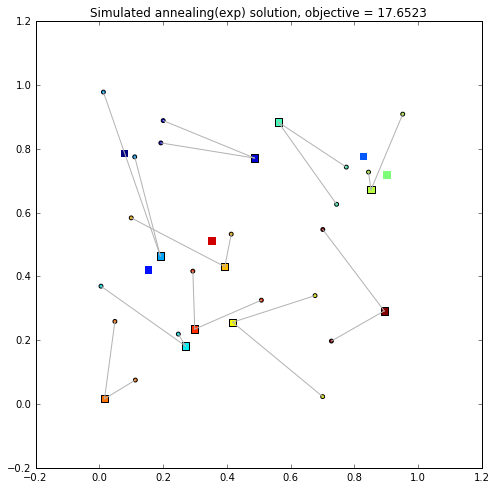

In [256]:
y_an, assignments_an = problem.solve_simulated_annealing(max_iter=30000 ,alpha=0.9,T_0=300,schedule='exp')
ax = plt.figure(figsize=(8,8)).gca()
problem.plot(y_an,assignments_an)
ax.set_title('Simulated annealing(exp) solution, objective = %.4f' % problem.objective(y_an, assignments_an))
print(y_an)
print(assignments_an)
print(problem.capacities)

25000
[12  8 12  9  6 13 14  5  4 10  6  8  9 14 11 10 13 11  4  5]
[ 0.  0.  0.  0.  1.  1.  1.  0.  1.  1.  1.  1.  1.  1.  1.]
[12  8 12  9  6 13 14  5  4 10  6  8  9 14 11 10 13 11  4  5]
[2 2 1 1 2 2 2 1 2 2 2 2 2 2 2]


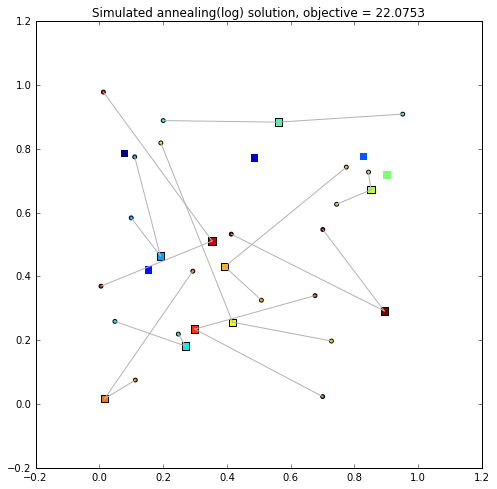

In [255]:
y_an, assignments_an = problem.solve_simulated_annealing(max_iter=25000 ,c=10,schedule='log')
ax = plt.figure(figsize=(8,8)).gca()
problem.plot(y_an,assignments_an)
ax.set_title('Simulated annealing(log) solution, objective = %.4f' % problem.objective(y_an, assignments_an))
print(y_an)
print(assignments_an)
print(problem.capacities)

*(Demonstrate your simulated annealing algorithm here. Try different sets of parameters and determine the best one)*

I implemented two temperature schedules: exponential and logarithmic T=c/log(1+N), where c=10 (see https://www.researchgate.net/publication/228600530_A_comparison_of_simulated_annealing_cooling_strategies for details). The last one is said to converge closely to global optima, however it works very slow and obtains worse solution than exponential cooling.

## Results comparison

*(Compare 4 methods (with their best parameters) on different problems, capacities etc. Don't forget corner cases like $C \gg F$, $C = F$, $\dots$)*

THE ARBITRARY PROBLEM GENERATED AT THE BEGINNING


TypeError: solve_greedy() got an unexpected keyword argument 'max_iter'

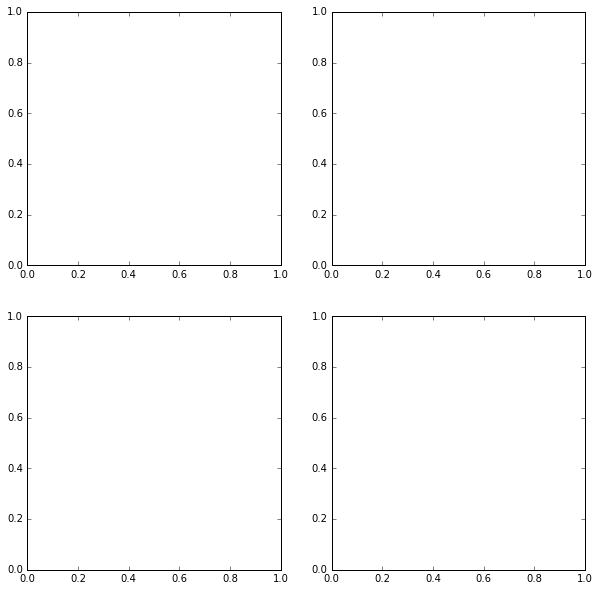

In [278]:
# Suggested code for comparison (modify as needed)

def compare_results(problem):
    fig = plt.figure(figsize=(10,10))

    ax_greedy = fig.add_subplot(221)
    ax_local  = fig.add_subplot(222)
    ax_anneal = fig.add_subplot(223)
    ax_gurobi = fig.add_subplot(224)

    greedy = problem.solve_greedy(max_iter=2**15)
    local  = problem.solve_local_optimization(max_iter=2**15)
    gurobi = problem.solve_gurobi()
    anneal = problem.solve_simulated_annealing(max_iter=30000 ,alpha=0.9,T_0=300,schedule='exp')

    ax_greedy.set_title('Greedy:    %.3f' % problem.objective(*greedy))
    ax_local .set_title('Local:     %.3f' % problem.objective(*local))
    ax_anneal.set_title('Annealing: %.3f' % problem.objective(*anneal))
    ax_gurobi.set_title('Gurobi:    %.3f' % problem.objective(*gurobi))

    problem.plot(greedy[0], greedy[1], ax_greedy)
    problem.plot(local [0], local [1], ax_local )
    problem.plot(anneal[0], anneal[1], ax_anneal)
    problem.plot(gurobi[0], gurobi[1], ax_gurobi)

    for ax in ax_greedy, ax_local, ax_anneal, ax_gurobi:
        ax.axes.get_xaxis().set_ticks([])
        ax.axes.get_yaxis().set_ticks([])
        
print("THE ARBITRARY PROBLEM GENERATED AT THE BEGINNING")
compare_results(problem)

THE C>>F PROBLEM
[ 0.88850485  0.02229083]
Greedy algorithm is working
[10, 12, 8, 2, 7, 8, 1, 1, 8, 5, 2, 2, 12, 13, 11, 1, 2, 8, 5, 10, 2, 2, 13, 5, 10, 5, 7, 11, 7, 5, 12, 0, 7, 12, 10, 12, 11, 11, 12, 10, 10, 13, 7, 7, 11, 11, 13, 13, 0, 0]
[1 1 1 0 0 1 0 1 1 0 1 1 1 1 0]
[ 0.88850485  0.02229083]
Greedy algorithm is working
[10, 12, 8, 2, 7, 8, 1, 1, 8, 5, 2, 2, 12, 13, 11, 1, 2, 8, 5, 10, 2, 2, 13, 5, 10, 5, 7, 11, 7, 5, 12, 0, 7, 12, 10, 12, 11, 11, 12, 10, 10, 13, 7, 7, 11, 11, 13, 13, 0, 0]
[1 1 1 0 0 1 0 1 1 0 1 1 1 1 0]
Local Search is working
GRBOUT  [7, 12, 8, 1, 7, 8, 10, 5, 13, 12, 11, 2, 12, 0, 13, 10, 10, 7, 12, 11, 5, 2, 13, 5, 10, 1, 7, 11, 8, 2, 12, 0, 7, 12, 10, 2, 11, 13, 2, 10, 5, 0, 5, 8, 11, 11, 13, 2, 7, 1]
GRBOUT  [1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0]


D:\Programs\Anaconda\lib\site-packages\ipykernel\__main__.py:124: RuntimeWarning: overflow encountered in double_scalars


30000
[10 12  8  2  7  8  1  1  8  5  2  2 12 13 11  1  2  8  5 10  2  2 13  5 10
  5  7 11  7  5 12  0  7 12 10 12 11 11 12 10 10 13  7  7 11 11 13 13  0  0]
[ 7 12  8  1  7  7 10  5  8 12 11  2 12  0 13 10 10  7 12 11  5  2 13  5 10
  1  7 13  8  2 12  0  7 12 11  2 11 13  2 10  5  0 10  8 11 11 13  2  5  1]
[10 12  8  1  8  8 10 14  9 12  6  2 12 13 11 10 14 10 12  9  5  2 13  5 10
  1  7 11  8  2 12 13  5 12  9  2 11 11  2 10 14 13  5  9  6 11 13  2  5  1]
[ 7 12  8  1  7  8 10  5 13 12 11  2 12  0 13 10 10  7 12 11  5  2 13  5 10
  1  7 11  8  2 12  0  7 12 10  2 11 13  2 10  5  0  5  8 11 11 13  2  7  1]


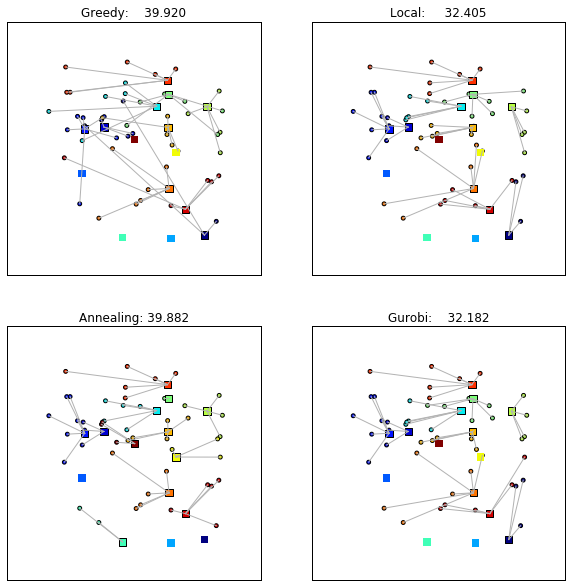

In [259]:
print("THE C>>F PROBLEM")
problem_cgf= Problem(C=50,F=15)
problem_cgf.assign_random_capacities()
problem_cgf.assign_random_opening_costs()
compare_results(problem_cgf)

THE C<<F PROBLEM
[ 0.71428044  0.00327945]
Greedy algorithm is working


KeyboardInterrupt: 

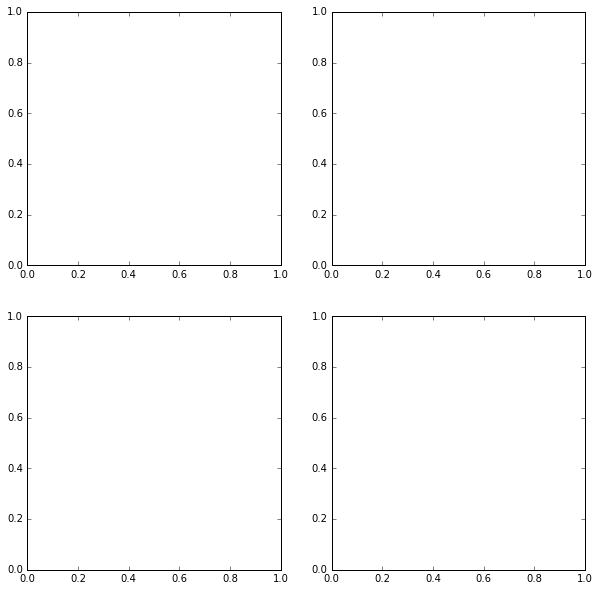

In [271]:
print("THE C<<F PROBLEM")
problem_clf= Problem(C=15,F=50)
problem_clf.assign_random_capacities2()
problem_clf.assign_random_opening_costs()
compare_results(problem_clf)

GreedyAlgorithm operates very slow on the large set of factories because it needs to consider every possible opening. So I had to add max_iteration parameter to it which bounds the search tree to reasonable size.
So we see that annealing is not as effective as other methods. Things are usually changed, however, in bigger instances. Greedy is the fastest algorithm and gives a reasonable quality of solution.

# Problem 2
**Optimal vehicle speed scheduling (6 points)** -- (based on an additional exercise A3.20 to Boyd and Vandenberghe). 

A vehicle (say, an airplane) travels along a fixed path of $n$ segments, between $n + 1$ waypoints labeled $0, \dots , n$. Segment $i$ starts at waypoint $i-1$ and terminates at waypoint $i$. The vehicle starts at time $t = 0$ at waypoint $0$. It travels over each segment at a constant (nonnegative) speed; $s_i$ is the speed on segment $i$. We have lower and upper limits on the speeds: $s_{\min} \leq s \leq s_{\max}$. The vehicle does not stop at the waypoints; it simply proceeds to the next segment. The travel distance of segment $i$ is $d_i$ (which is positive), so the travel time over segment $i$ is $\frac{d_i}{s_i}$. We let $\tau_i$, $i = 1, \dots, n$ denote the time at which the vehicle arrives at waypoint $i$. The vehicle is required to arrive at waypoint $i$, $i = 1, \dots, n$, between times $\tau_{\min,i}$ and $\tau_{\max,i}$, which are given. The vehicle consumes fuel over segment $i$ at a rate that depends on its speed $\Phi\left(s_i\right) = a s_i^2+b s_i+c$ kg/s.

You are given the data $d$ (segment travel distances), $s_{\min}$ and $s_{\max}$ (speed bounds), $\tau_{\min}$ and $\tau_{\max}$ (waypoint arrival time bounds), and parameters $a$, $b$, and $c$ (all parameters are in *veh_speed_sched_data.m*). Use the dynamic programming approach to find the schedule that allows spending the minimal amount of fuel. Use matplotlib command *step* to plot speed vs time for the optimal schedule. You will need to discretize some continuous variables, make sure you do it densely enough.

**NB**: later in the course we will get back to this problem and attack it with a different method.


In [26]:
import scipy.io as sio

mat_contents = sio.loadmat('veh_sched_data.mat')

a = mat_contents['a'][0,0]
b = mat_contents['b'][0,0]
c = mat_contents['c'][0,0]
d = mat_contents['d'].squeeze()
n = mat_contents['n'][0,0]
smin = mat_contents['smin'].squeeze()
smax = mat_contents['smax'].squeeze()
tau_min = mat_contents['tau_min'].squeeze()
tau_max = mat_contents['tau_max'].squeeze()

In [281]:
def IntersectSegments(seg0,seg1):
    left = np.max([seg0[0],seg1[0]])
    right = np.min([seg0[1],seg1[1]])
    if(right<left):
        return None
    else:
        return np.array([left,right])
        
    
def ComputeFeasibleDecisions(v_seg,t_seg,d,t):# computes feasible speeds at time t
    return IntersectSegments([d/(t_seg[1]-t),d/(t_seg[0]-t)],v_seg)

def Fuel(coefs,v):
    return coefs[0]*v**2+coefs[1]*v+coefs[2]



def ComputeFeasibilityRegions(a,b,c,d,n,smin,smax,tau_min,tau_max):
    T=[]
    testRange=[d[0]/smax[0],d[0]/smin[0]]
    T.append(IntersectSegments(testRange,[tau_min[0],tau_max[0]]))
    for N in np.arange(1,n):
        #print(N)
        #print(T)
        #print("Intersecting")
        #print(d[N]/smin[N],d[N]/smax[N])
        #print([T[-1][0]+d[N]/smax[N],T[-1][1]+d[N]/smin[N]])
        #print([tau_min[N],tau_max[N]])
        
        T.append(IntersectSegments([T[-1][0]+d[N]/smax[N],T[-1][1]+d[N]/smin[N]],[tau_min[N],tau_max[N]]))

    return T
    
    


In [294]:
feasRegions=ComputeFeasibilityRegions(a,b,c,d,n,smin,smax,tau_min,tau_max)
feasRegions[-2:]

[array([ 153.2647,  156.5266]), array([ 154.4994,  157.6903])]

In [308]:

def BuildPolicy(feasibilityRegions,a,b,c,d,n,smin,smax,tau_min,tau_max):
    #policy is computed as speeds
    #ok now we can test different endTimes
    
    tn_grid = np.linspace(feasibilityRegions[-1][0],feasibilityRegions[-1][1],num=100)
    cost_opt=np.Inf
    policy_opt=[]
    states_opt=[]
    for tn in tn_grid:
        policy=[]
        states=[tn]
        
        for i in np.arange(len(feasibilityRegions)-1,0,-1):
            #tt=IntersectSegments(feasibilityRegions[i-1],[states[0]-d[i]/smin[i],states[0]-d[i]/smax[i]])[0]
            
            v=np.sqrt(c/(d[i]*a))
            if(v<smin[i]): #to enforce feasibility
                v=smin[i]
            else:
                if(v>smax[i]):
                    v=smax[i]
            states=[states[0]-d[i]/v]+states
                
            #print(smin[i],v,smax[i])
            policy=[v]+policy
        policy=[d[0]/(states[0])]+policy
        states=[0]+states
        cost=np.sum([Fuel([a,b,c],policy[i])*(states[i+1]-states[i]) for i in np.arange(len(policy))])
        if(cost<cost_opt):
            cost_opt=cost
            states_opt=np.array(states)
            policy_opt=np.array(policy)
            
    return policy_opt, states_opt

(policy,states)=BuildPolicy(feasRegions,a,b,c,d,n,smin,smax,tau_min,tau_max)
print(np.array(states))


[   0.           69.75085069   70.51856084   71.49599256   72.44605969
   73.54603643   74.46908515   75.57307969   76.33508777   77.27057827
   77.81969731   78.46895951   79.74098336   80.93918774   81.66387332
   82.48251066   83.07827248   83.9297825    84.94455222   85.47417573
   88.79569827   89.68513833   90.23903802   91.0504221    91.49033149
   91.90632243   92.32902495   92.87830781   93.86775812   94.88559955
   95.75398057   96.40527315   97.1353436    97.93795399   98.78702349
   99.4694553   100.24604697  101.10638528  102.06418483  102.50259393
  103.6601571   104.69390099  105.95126934  106.64066385  107.20859304
  107.99259488  108.82172591  109.7180191   110.65346919  111.26858541
  111.73662113  112.4373022   115.42204315  116.37514872  117.03967458
  117.58756566  118.28719524  118.79895119  120.19923727  121.24245861
  121.87862245  122.87882294  123.70688298  124.80768066  125.64962159
  126.81822736  127.82130875  128.31292788  129.02871209  129.5591032
  130.3

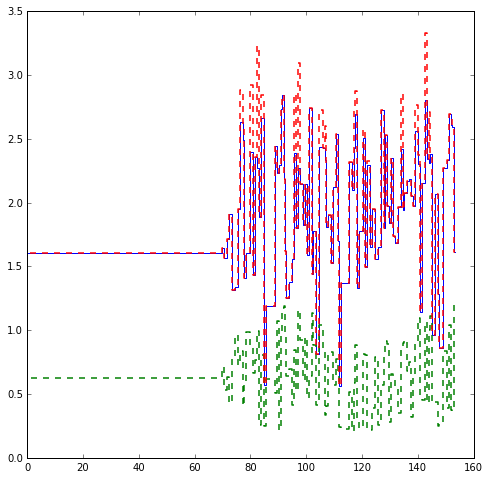

In [309]:
plt.figure(figsize=(8,8))
plt.step(states[:-1],policy)

plt.plot(states[:-1], smin, linestyle='--',linewidth=1.5, drawstyle='steps')
plt.plot(states[:-1], smax, linestyle='--',linewidth=1.5, drawstyle='steps')




In [310]:
print(len(policy))
print(len(states))
print(np.sum([Fuel([a,b,c],policy[i])*(states[i+1]-states[i]) for i in np.arange(len(policy))]))

100
101
2758.73646783


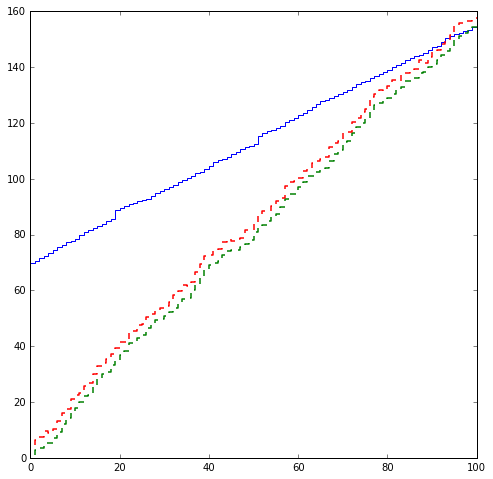

In [311]:
plt.figure(figsize=(8,8))
plt.step(np.arange(0,len(states)),states[:])

plt.plot(np.arange(1,len(states)),tau_min, linestyle='--',linewidth=1.5, drawstyle='steps')
plt.plot(np.arange(1,len(states)),tau_max, linestyle='--',linewidth=1.5, drawstyle='steps')

In [279]:
Fuel([a,b,c],1)

8

In [280]:
print(a,b,c)

1 6 10
